In [1]:
import sys  
sys.path.insert(0, r'C:\Users\marci\Desktop\Python\Numba-tutorial')
import numpy as np
import matplotlib.pyplot as plt
from numba import int64, int32, float64, float32, cuda, guvectorize

In [2]:
from codes.FractionalAbundance import FractionalAbundance

In [56]:
FA = FractionalAbundance(element="He", concurrent=True)

In [57]:
K = FA.K

In [58]:
FA_output = np.zeros_like(K)

In [59]:
for i in range(K.shape[1]):
    for j in range(K.shape[2]):
        sum_all = 0
        current_product = K[0,i,j]
        product_all = []
        for k in range(K.shape[0]):
            current_product *= K[k,i,j]
            sum_all += current_product
            product_all.append(current_product)
        for k in range(K.shape[0]):    
            FA_output[k,i,j] = product_all[k]/sum_all
        

In [65]:
np.array_equal(FA_output, FA.FA_arr)

False

In [67]:
np.allclose(FA_output, FA.FA_arr)

False

In [63]:
FA_output

array([[[2.00488757e-03, 1.99819970e-03, 1.99152362e-03, ...,
         1.29155375e-03, 1.29037550e-03, 1.30024630e-03],
        [1.87507226e-03, 1.86840457e-03, 1.86170592e-03, ...,
         1.18396706e-03, 1.18199627e-03, 1.19037307e-03],
        [1.75299512e-03, 1.74633927e-03, 1.73961949e-03, ...,
         1.08362029e-03, 1.08108684e-03, 1.08837478e-03],
        ...,
        [2.81659659e-16, 2.79133876e-16, 2.76522406e-16, ...,
         3.80586245e-17, 3.70666543e-17, 3.63147486e-17],
        [2.75388757e-16, 2.72920212e-16, 2.70368186e-16, ...,
         3.72078588e-17, 3.62375276e-17, 3.55403040e-17],
        [2.69256339e-16, 2.66844299e-16, 2.64350858e-16, ...,
         3.63799896e-17, 3.54307990e-17, 3.47823303e-17]],

       [[8.74624706e-01, 8.74719606e-01, 8.74764243e-01, ...,
         8.25353511e-01, 8.25056711e-01, 8.30284953e-01],
        [8.60479770e-01, 8.60568018e-01, 8.60603422e-01, ...,
         8.06670722e-01, 8.06343907e-01, 8.12114775e-01],
        [8.45106225e-01, 

In [64]:
FA.FA_arr

[array([[2.00891522e-03, 2.00220049e-03, 1.99549770e-03, ...,
         1.29322402e-03, 1.29204272e-03, 1.30193915e-03],
        [1.87859476e-03, 1.87190204e-03, 1.86517833e-03, ...,
         1.18537050e-03, 1.18339504e-03, 1.19179175e-03],
        [1.75607351e-03, 1.74939431e-03, 1.74265103e-03, ...,
         1.08479579e-03, 1.08225685e-03, 1.08956063e-03],
        ...,
        [2.81659659e-16, 2.79133876e-16, 2.76522406e-16, ...,
         3.80586245e-17, 3.70666543e-17, 3.63147486e-17],
        [2.75388757e-16, 2.72920212e-16, 2.70368186e-16, ...,
         3.72078588e-17, 3.62375276e-17, 3.55403040e-17],
        [2.69256339e-16, 2.66844299e-16, 2.64350858e-16, ...,
         3.63799896e-17, 3.54307990e-17, 3.47823303e-17]]),
 array([[8.76381753e-01, 8.76470970e-01, 8.76509833e-01, ...,
         8.26420878e-01, 8.26122719e-01, 8.31365933e-01],
        [8.62096262e-01, 8.62178917e-01, 8.62208601e-01, ...,
         8.07626925e-01, 8.07298130e-01, 8.13082647e-01],
        [8.46590293e-01, 

### Numba

In [10]:
import math
from numba import cuda
import math 
from numba import float32, float64
from pdb import set_trace

In [43]:
array_K = K.copy()

In [44]:
threadsperblock = (3, 5, 5)
blockspergrid_x = math.ceil(array_K.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(array_K.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(array_K.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
print(blockspergrid)
print(threadsperblock)
print(array.shape)

(1, 160, 20)
(3, 5, 5)
(4, 2, 1)


In [45]:
@cuda.jit
def increment_a_2D_array(X,Y):
    cuda.syncthreads()
    k, j, i = cuda.grid(3)
    if i < X.shape[2] and j < X.shape[1] and k < X.shape[0]:
        sum_all = 0
        current_product = 1
        cuda.syncthreads()
        for k in range(X.shape[0]):
            current_product *= X[k,j,i]
            sum_all += current_product
            Y[k, j, i] = current_product
            cuda.syncthreads()
        for k in range(X.shape[0]):
            Y[k, j, i] = Y[k, j, i] / sum_all
            cuda.syncthreads()
    cuda.syncthreads()

(5, 20000)

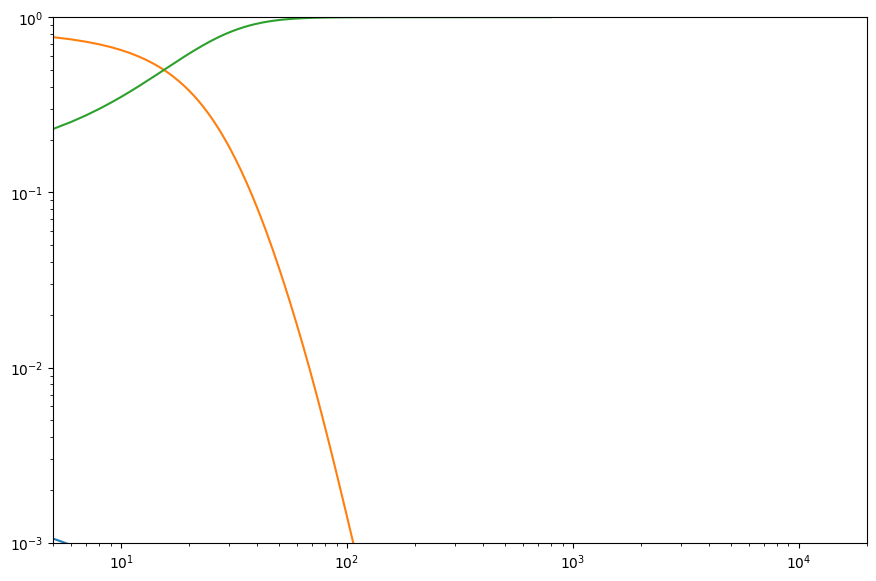

In [70]:
# X array
device_array = cuda.to_device((array_K).astype(np.float64))
# Y array
result_array = cuda.to_device(np.ones_like(array_K).astype(np.float64))
increment_a_2D_array[blockspergrid, threadsperblock](device_array,
                                                     result_array)
result_gpu = result_array.copy_to_host()
plt.plot(result_gpu[0,: ,50])
plt.plot(result_gpu[1,: ,50])
plt.plot(result_gpu[2,: ,50])
plt.xscale("log")
plt.yscale("log")
plt.ylim((10**-3, 10**0))
plt.xlim((5, 20000))

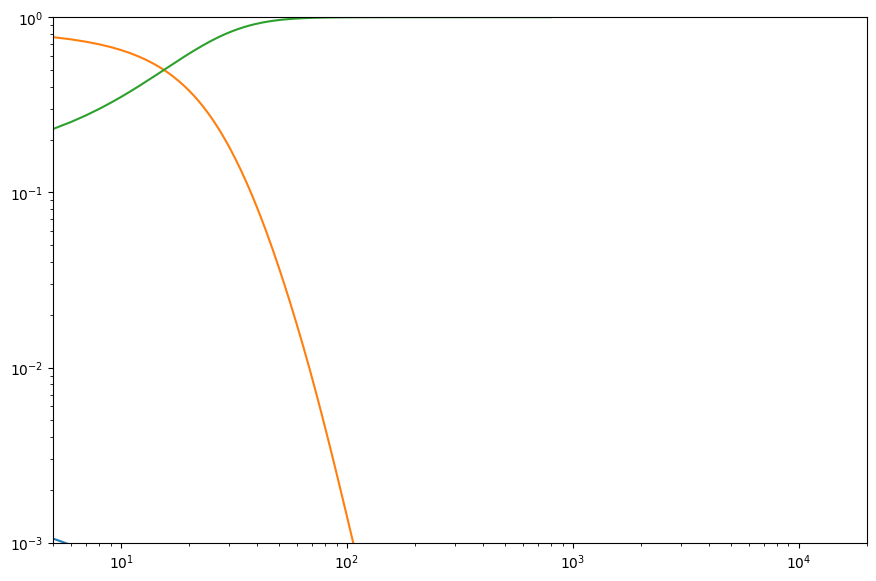

In [68]:
for ion in range(FA.Z+1):
    plt.plot(FA_output[ion,:,50])
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim((10**-3, 10**0))
    plt.xlim((5, 20000))

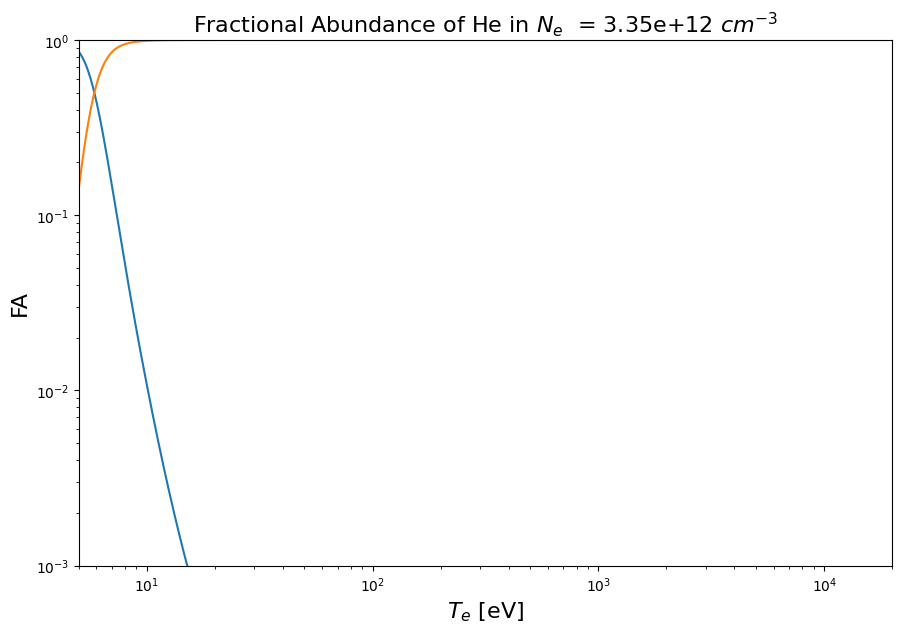

In [51]:
FA.plot_FA_all()

In [21]:
np.random.seed(1)
array_random = np.random.rand(3,2,1)
array_random

array([[[4.17022005e-01],
        [7.20324493e-01]],

       [[1.14374817e-04],
        [3.02332573e-01]],

       [[1.46755891e-01],
        [9.23385948e-02]]])

In [22]:
array = np.insert(array_random,[0],[1,1]).reshape(4,2,1)
array

array([[[1.00000000e+00],
        [1.00000000e+00]],

       [[4.17022005e-01],
        [7.20324493e-01]],

       [[1.14374817e-04],
        [3.02332573e-01]],

       [[1.46755891e-01],
        [9.23385948e-02]]])

In [23]:
array[1][1][0]

0.7203244934421581

In [24]:
def multidim_cumsum(array,sums=False):
    array_out = []
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            if sums:
                array_out.append(np.cumprod(array[:,i,j])/np.cumprod(array[:,i,j]).sum())
            else:
                array_out.append(np.cumprod(array[:,i,j]))
    return np.array(array_out).T.reshape(4,2,1)

In [25]:
multidim_cumsum(array)

array([[[1.00000000e+00],
        [1.00000000e+00]],

       [[4.17022005e-01],
        [7.20324493e-01]],

       [[4.76968156e-05],
        [2.17777557e-01]],

       [[6.99978866e-06],
        [2.01092736e-02]]])

In [26]:
array.shape

(4, 2, 1)

In [27]:
array[0, 1, 0]

1.0

In [28]:
threadsperblock = (2, 2, 1)
blockspergrid_x = math.ceil(array.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(array.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(array.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
print('blocks',blockspergrid)
print('threads',threadsperblock)
print(array.shape)

blocks (2, 1, 1)
threads (2, 2, 1)
(4, 2, 1)


In [29]:
from numba import cuda
import math 
from numba import float32 
@cuda.jit()
def cum_prod(X,Y):
    cuda.syncthreads()
    k, j, i = cuda.grid(3)
    if i < X.shape[2] and j < X.shape[1] and k < X.shape[0]:
        current_product = 1
        sum_all = 0
        for k in range(X.shape[0]):
            current_product *= X[k,j,i]
            Y[k, j, i] = current_product
            sum_all += current_product
        cuda.syncthreads()
        for k in range(X.shape[0]):
            Y[k, j, i] = Y[k, j, i] / sum_all

In [30]:
# X array
device_array = cuda.to_device((array).astype(np.float32))
# Y array
result_array = cuda.device_array_like(device_array)

cum_prod[blockspergrid, threadsperblock](device_array,
                                                     result_array)
cuda.synchronize()
result_gpu = result_array.copy_to_host()
result_gpu

C:\Users\marci\AppData\Roaming\Python\Python39\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([[[7.0567811e-01],
        [5.1067013e-01]],

       [[2.9428330e-01],
        [3.6784819e-01]],

       [[3.3658598e-05],
        [1.1121249e-01]],

       [[4.9395971e-06],
        [1.0269205e-02]]], dtype=float32)

In [33]:
np.array_equal(result_gpu, multidim_cumsum(array,sums=True))

False

In [34]:
 multidim_cumsum(array,sums=True)

array([[[7.05678104e-01],
        [5.10670114e-01]],

       [[2.94283298e-01],
        [3.67848191e-01]],

       [[3.36585984e-05],
        [1.11212490e-01]],

       [[4.93959759e-06],
        [1.02692050e-02]]])